# Stroke Trial experiments
Code for experiments on the International Stroke Trial dataset.

Data can be downloaded at https://datashare.ed.ac.uk/handle/10283/124

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Preprocess data

In [4]:
df = pd.read_csv("data/ist/IST_corrected.csv", index_col=False, encoding_errors='replace')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Filter missing outcomes
df = df[df['OCCODE'] < 5]

# Filter out no aspirin allocated
df = df[df['RXASP'] == 'Y']

# Filter out low heparin
df = df[df['RXHEP'] != 'L']

In [6]:
# Remap the treatments to 0,1
df['T'] = (((df['RXHEP'] == 'H').astype(int)) + ((df['RXHEP'] == 'M').astype(int))) * ((df['RXASP'] == 'Y').astype(int)) 

## Create scalarized outcome variable
Scalarized score: Y = -2I[death] - I[recurrent stroke]-0.5I[pulmonary embolism or intracranial bleeding]
-0.5I[other side effects] + 2I[full recovery at 6 months] + I[discharge within 14 days]

In [7]:
df['death'] = (df['OCCODE'] == 1).astype(int)
df['death'].mean()

0.21640969162995594

In [8]:
df['recurrent_stroke'] = df['STRK14']
df['recurrent_stroke'].mean()

0.040198237885462555

In [9]:
df['emb_bleeding'] = df['PE14'] + df['H14']
df['emb_bleeding'].mean()

0.015418502202643172

In [10]:
df['other_side_effects'] = df['HTI14'] + df['DVT14'] + df['TRAN14'] + df['NCB14']
df['other_side_effects'] = (df['other_side_effects'] > 0).astype(int)
df['other_side_effects'].mean()

0.04377753303964758

In [11]:
df['recovery'] = (df['OCCODE'] == 4).astype(int)
df['recovery'].mean()

0.17373348017621146

In [12]:
df['discharge'] = (df['DALIVE'] == 'Y').astype(int) 
df['discharge'].mean()

0.5357929515418502

In [13]:
df['Y'] = -2*df['death'] - df['recurrent_stroke'] - 0.5*df['emb_bleeding'] - 0.5*df['other_side_effects'] + 2*df['recovery'] + df['discharge']

## Preprocess features

In [14]:
x_columns = ['RDELAY', 'RCONSC', 'SEX', 'AGE', 'RSLEEP', 'RATRIAL', 'RCT',
 'RVISINF', 'RHEP24', 'RASP3', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5',
 'RDEF6', 'RDEF7', 'RDEF8', 'STYPE']

In [15]:
# Filter down to just relevant columns
df = df[['Y', 'T'] + x_columns]

In [16]:
# one-hot encode categorical features
df = pd.get_dummies(df, dummy_na=True)

In [17]:
df = df.fillna(0)

# Fit model

We assume the outcome model is linear with interaction terms between the features and treatment.

In [41]:
class OutcomeModel:
    """Fits an outcome model."""
    
    def __init__(self, t_column, x_columns, y_column):
        self.t_column = t_column
        self.x_columns = x_columns
        self.y_column = y_column
    
    def fit_outcome(self, df_input):
        """Fits outcome model E[Y | X = x, T = t] using df_input."""
        raise("Not Implemented")
    
    def predict_Ys(self, df_input):
        """Returns a numpy array of predictions for each row in df_input."""
        raise("Not Implemented")

class OutcomeModelLinear(OutcomeModel):
    """Fits a linear model with interaction terms."""
    
    def __init__(self, t_column, x_columns, y_column):
        super().__init__(t_column, x_columns, y_column)
    
    def get_input_columns(self, df_input, deep_copy=False):
        inputs = df_input[[self.t_column] + self.x_columns].copy(deep=deep_copy)
        for x_column in self.x_columns:
            inputs[x_column + '*T'] = inputs[x_column] * inputs[self.t_column]
        return inputs
    
    def get_target_column(self, df_input):
        # Transforms y column values from -1,1 to 0,1. 
        return df_input[self.y_column]
    
    def fit_outcome(self, df_input):
        """Fits logistic regression model on Y given X, T.
        
        If update_internal is True, updates internal outcome model.
        
        """
        inputs = self.get_input_columns(df_input)
        target = self.get_target_column(df_input)
        clf_outcome = LinearRegression().fit(inputs, target)     
        self.clf_outcome = clf_outcome
        self.print_metrics(df_input)
        return clf_outcome
    
    def print_metrics(self, df_input):
        y_true = self.get_target_column(df_input)
        inputs = self.get_input_columns(df_input)
        print("R^2 for outcome model: %f" % self.clf_outcome.score(inputs, y_true))
        y_pred = self.predict_Ys(df_input)
        mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
        print("RMSE for outcome model: %f" % np.sqrt(mse))
        print('Coefficients for outcome model:', self.clf_outcome.coef_)
        
    def predict_Ys(self, df_input):
        """Predicts outcome Y for given df_input.
        
        """
        inputs = self.get_input_columns(df_input)
        return self.clf_outcome.predict(inputs)
        
    def predict_mu_0s(self, df_input):
        """Returns a numpy array of mu_0(x) values for each row in df_input.
        """
        df_input_cf = df_input.copy(deep=True)
        df_input_cf['T'] = 0
        Y_means = self.predict_Ys(df_input_cf)
        return Y_means
    
    def predict_mu_0s_marginal(self, df_input, df_train, x_obs):
        """Returns a numpy array of mu_0(x) values for each row in df_input.
        
        if cols_to_use is None, then uses all columns. Otherwise, outputs average mu_0s over cols_to_use.
        For each row i in df_input, outputs
            E[E[Y(0) | x_obs, x_columns - x_obs] | x_obs = x_obs_i] = E_{df_train}[mu_0 | x_obs = x_obs_i].
        For each input row an average is taken over the training dataset, df_train.
        """ 
        results = []
        # If x_obs is none or empty
        if not x_obs:
            # Get average value for the row over df_train.
            df_filtered = df_train
            # Evaluate mu_0
            mu_0s_filtered = self.predict_mu_0s(df_filtered)
            mu_0_marg = mu_0s_filtered.mean()
            results = [mu_0_marg] * len(df_input)
        else:
            mu_0s_predicted = self.predict_mu_0s(df_train)
            df_train['mu_0'] = mu_0s_predicted
            grouped = df_train.groupby(x_obs).mean()
            print(grouped['mu_0'])
            mu_0_map = grouped['mu_0']
            # Apply grouped results to input df
            for _, row in df_input.iterrows():
                # Get correct row
                if len(x_obs) > 1:
                    mu_0_result = mu_0_map[tuple(row[x_obs].values)]
                else:
                    mu_0_result = mu_0_map[row[x_obs].values[0]]
                results.append(mu_0_result)
        return np.array(results)
    
    def predict_mu_1s(self, df_input):
        """Returns a numpy array of mu_1(x) values for each row in df_input."""
        df_input_cf = df_input.copy(deep=True)
        df_input_cf['T'] = 1
        Y_means = self.predict_Ys(df_input_cf)
        return Y_means


In [19]:
t_column = 'T'
y_column = 'Y'
x_columns = list(df.columns)
x_columns.remove(t_column)
x_columns.remove(y_column)

In [20]:
outcome_model = OutcomeModelLinear(t_column, x_columns, y_column)

In [21]:
outcome_model.fit_outcome(df)

R^2 for outcome model: 0.269755
RMSE for outcome model: 1.346663
Coefficients for outcome model: [ 4.51884395e-02  9.31945716e-05 -2.22622144e-02  1.67717726e-03
  7.89154197e-03  6.16550714e-01 -6.24442256e-01  1.93543098e-14
 -3.65338612e-02  3.65338612e-02  3.99680289e-15  1.27643454e-03
 -1.27643454e-03  2.52228793e-15  1.28928602e-01 -8.62923965e-02
 -4.26362058e-02 -1.07172712e-01  1.07172712e-01 -6.16173779e-15
  1.08424275e-01 -1.08424275e-01  7.28583860e-17 -4.50897729e-02
  9.50264006e-02 -4.99366277e-02  3.37954975e-02  8.84070826e-03
 -4.26362058e-02 -2.58614432e-01  2.27632265e-01  3.09821671e-02
  4.71844785e-16  4.06343208e-01 -8.39661828e-02 -3.22377026e-01
 -2.22044605e-16 -1.27070243e-01  2.65775517e-01 -1.38705274e-01
 -3.33066907e-16 -2.88573327e-01  2.15021016e-01  7.35523109e-02
  2.35922393e-16 -7.66470724e-02  1.14457823e-01 -3.78107503e-02
  3.05311332e-16 -1.61068971e-01  2.19015034e-01 -5.79460630e-02
  0.00000000e+00 -1.31829152e-01  1.48100876e-03  1.303481

LinearRegression()

# Calculate regrets

In [22]:
mu_0s = outcome_model.predict_mu_0s(df)

In [23]:
mu_1s = outcome_model.predict_mu_1s(df)

In [26]:
# ATE
mu_1s.mean() - mu_0s.mean()

-0.16154740035064136

In [27]:
print("Number of units where treatment would be good: %d" % (mu_1s - mu_0s > 0).sum())

Number of units where treatment would be bad: 1360


In [40]:
print("Number of units where treatment would be bad: %d" % (mu_1s - mu_0s < 0).sum())

Number of units where treatment would be bad: 5904


In [29]:
T_OPT = (mu_1s > mu_0s).astype(int)
V_OPT = ((mu_1s - mu_0s)* T_OPT).mean()
print("Optimal utility: %f" % V_OPT)
print("Optimal probability of treatment: %f" % T_OPT.mean())

Optimal utility: 0.025186
Optimal probability of treatment: 0.187225


In [30]:
# ATO reward:
T_ATO = (mu_1s == mu_1s.max()).astype(int)
V_ATO = ((mu_1s - mu_0s) * T_ATO).mean()
R_ATO = V_OPT - V_ATO
print("ATO utility: %f, ATO regret: %f" % (V_ATO, R_ATO))
print("ATO probability of treatment: %f" % T_ATO.mean())

ATO utility: 0.000041, ATO regret: 0.025145
ATO probability of treatment: 0.000138


In [31]:
# Total treated outcome reward: 
T_TO = (mu_1s > 0).astype(int)
V_TO = ((mu_1s - mu_0s) * T_TO).mean()
R_TO = V_OPT - V_TO
print("TO utility: %f, TO regret: %f" % (V_TO, R_TO))
print("TO probability of treatment: %f" % T_TO.mean())

TO utility: -0.082775, TO regret: 0.107961
TO probability of treatment: 0.668915


In [32]:
# ATT reward:
T_ATT = (mu_1s - mu_0s == (mu_1s - mu_0s).max()).astype(int)
V_ATT = ((mu_1s - mu_0s) * T_ATT).mean()
R_ATT = V_OPT - V_ATT
print("ATT utility: %f, ATT regret: %f" % (V_ATT, R_ATT))
print("ATT probability of treatment: %f" % T_ATT.mean())

ATT utility: 0.000131, ATT regret: 0.025055
ATT probability of treatment: 0.000138


# Information asymmetry

## Demographic information
Suppose the principal identifies $E[Y(0) | X]$ where $X$ includes age and sex only.

In [34]:
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, ['AGE', 'SEX_F', 'SEX_M', 'SEX_nan'])
# TT reward
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
print("demographic info utility: %f, demographic info regret: %f" % (V_TT, R_TT))
print("demographic info probability of treatment: %f" % T_TT.mean())

AGE  SEX_F  SEX_M  SEX_nan
25   1      0      0          0.170687
26   1      0      0          1.597416
27   1      0      0          1.742476
28   0      1      0         -0.791344
     1      0      0          2.357934
                                ...   
96   0      1      0         -0.826785
     1      0      0         -0.473799
97   0      1      0         -0.739203
     1      0      0         -0.435770
98   1      0      0         -0.973564
Name: mu_0, Length: 143, dtype: float64
demographic info utility: -0.063917, demographic info regret: 0.089102
demographic info probability of treatment: 0.504130


 ## No information
 Suppose the principal gets no features and just identifies $E[Y(0)]$.

In [36]:
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
print("no info utility: %f, no info regret: %f" % (V_TT, R_TT))
print("no info probability of treatment: %f" % T_TT.mean())

no info utility: -0.048886, no info regret: 0.074072
no info probability of treatment: 0.482930


## Individual features

In [39]:
feature_groups = {'Delay': ['RDELAY'],
                  'Age': ['AGE'], 
                  'Blood pressure': ['RSBP'], 
                  'Conciousness': ['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan'], 
                  'Sex': ['SEX_F', 'SEX_M', 'SEX_nan'], 
                  'Sleep symptoms': ['RSLEEP_N', 'RSLEEP_Y', 'RSLEEP_nan'],
                  'Atrial fibrillation': ['RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan'],
                  'CT done': ['RCT_N', 'RCT_Y', 'RCT_nan'], 
                  'Infact visible': ['RVISINF_N', 'RVISINF_Y', 'RVISINF_nan'], 
                  'Heparin prior': ['RHEP24_N', 'RHEP24_Y', 'RHEP24_nan'], 
                  'Aspirin prior': ['RASP3_N', 'RASP3_Y', 'RASP3_nan'], 
                  'Face deficit': ['RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan'],
                  'Arm/hand deficit': ['RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan'], 
                  'Leg/foot deficit': ['RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan'], 
                  'Dysphasia': ['RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan'], 
                  'Hemianopia': ['RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan'], 
                  'Visuospatial disorder': ['RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan'], 
                  'Brainstem/cerebellar signs': ['RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan'], 
                  'Other deficit': ['RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan'], 
                  'Stroke subtype': ['STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan']}


In [59]:
# Calculate gamma_margs for each individual feature
gamma_margs = {}
for name, feature_group in feature_groups.items():
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    gamma_marg = (np.abs(mu_0s_marginal - mu_0s)).mean()
    gamma_margs[name] = gamma_marg

RDELAY
1     0.182032
2     0.188275
3     0.180960
4     0.205216
5     0.310787
6     0.273910
7     0.357784
8     0.333541
9     0.364841
10    0.454152
11    0.546272
12    0.424453
13    0.546671
14    0.493338
15    0.483538
16    0.487205
17    0.421461
18    0.457543
19    0.478507
20    0.509062
21    0.300512
22    0.513023
23    0.448133
24    0.534667
25    0.510425
26    0.534678
27    0.525900
28    0.475028
29    0.589710
30    0.463775
31    0.444207
32    0.512067
33    0.526257
34    0.439361
35    0.682916
36    0.462856
37    0.387673
38    0.466593
39    0.391780
40    0.492274
41    0.588659
42    0.532788
43    0.450150
44    0.620999
45    0.420762
46    0.399480
47    0.563802
48    0.495570
Name: mu_0, dtype: float64
AGE
25    0.170687
26    1.597416
27    1.742476
28    0.783295
29    1.791293
        ...   
94   -0.194076
95   -0.631973
96   -0.574653
97   -0.486342
98   -0.973564
Name: mu_0, Length: 74, dtype: float64
RSBP
80    -0.528602
85     0.810528
9

In [60]:
gamma_margs

{'Delay': 0.6373125923370251,
 'Age': 0.5653535007322553,
 'Blood pressure': 0.6368320104288473,
 'Conciousness': 0.44360520287240157,
 'Sex': 0.6301660694104128,
 'Sleep symptoms': 0.6458554317513233,
 'Atrial fibrillation': 0.6040311345832378,
 'CT done': 0.6450285929389888,
 'Infact visible': 0.6377245824752066,
 'Heparin prior': 0.6461841812865015,
 'Aspirin prior': 0.6458817426716775,
 'Face deficit': 0.5955143022050047,
 'Arm/hand deficit': 0.6033256890229672,
 'Leg/foot deficit': 0.5729727671592819,
 'Dysphasia': 0.5557869310217124,
 'Hemianopia': 0.4632322762556463,
 'Visuospatial disorder': 0.45595056669855083,
 'Brainstem/cerebellar signs': 0.5867636998636343,
 'Other deficit': 0.6040245514101399,
 'Stroke subtype': 0.46715860697703315}

In [61]:
sorted_gamma_margs = dict(sorted(gamma_margs.items(), key=lambda item: item[1]))

In [82]:
# Calculate gamma_marg for no features
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
none_gamma_marg = (np.abs(mu_0s_marginal - mu_0s)).mean()
print(none_gamma_marg)

0.6466038292378895


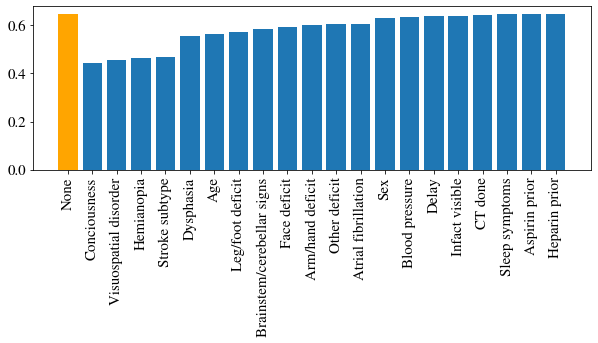

In [83]:
plt.figure(figsize = (10, 3))
plt.bar('None', none_gamma_marg, color='orange')
plt.bar(sorted_gamma_margs.keys(), sorted_gamma_margs.values())
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/ist_gammas.pdf', format='pdf', bbox_inches = "tight")
plt.show()

In [63]:
# Regret for individual features
regrets_individual = {}
for name in sorted_gamma_margs.keys():
    feature_group = feature_groups[name]
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
    V_TT = ((mu_1s - mu_0s) * T_TT).mean()
    R_TT = V_OPT - V_TT
    regrets_individual[name] = R_TT
regrets_individual

RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan
0         0         1         0            -1.558628
          1         0         0             0.746756
1         0         0         0            -0.522810
Name: mu_0, dtype: float64
RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan
0        0        1        0           -0.110850
         1        0        0            0.820527
1        0        0        0           -0.496480
Name: mu_0, dtype: float64
RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan
0        0        1        0           -0.019960
         1        0        0            0.831339
1        0        0        0           -0.440487
Name: mu_0, dtype: float64
STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan
0           0          0           0           1           0           -0.400951
                                   1           0           0            0.682622
                       1           0           0           0            0.534801
            1          0           0   

{'Conciousness': 0.06189294424196044,
 'Visuospatial disorder': 0.04943349162634397,
 'Hemianopia': 0.06025340360134128,
 'Stroke subtype': 0.053504648484883024,
 'Dysphasia': 0.058319951299717926,
 'Age': 0.09312036303537903,
 'Leg/foot deficit': 0.06815717418633027,
 'Brainstem/cerebellar signs': 0.06725966617819287,
 'Face deficit': 0.06185069071288561,
 'Arm/hand deficit': 0.06667432368555333,
 'Other deficit': 0.06984656756571629,
 'Atrial fibrillation': 0.06787540792536177,
 'Sex': 0.07183403449413378,
 'Blood pressure': 0.07324083166967528,
 'Delay': 0.07442849555581944,
 'Infact visible': 0.07064526871174677,
 'CT done': 0.07586830812771798,
 'Sleep symptoms': 0.07448398254225094,
 'Aspirin prior': 0.07366382198572863,
 'Heparin prior': 0.07404741073809394}

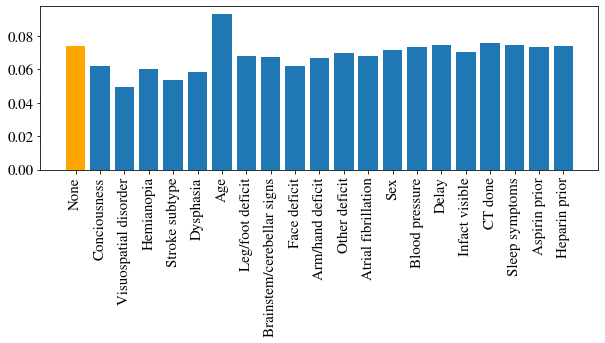

In [79]:
# Plot regrets with the same sorted order as the gamma_margs.
plt.figure(figsize = (10, 3))
plt.bar('None', regrets_cumulative['None'], color='orange')
plt.bar(regrets_individual.keys(), regrets_individual.values())
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/ist_regrets_indiv.pdf', format='pdf', bbox_inches = "tight")
plt.show()

In [65]:
regrets_cumulative = {}
feature_group = []
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
regrets_cumulative['None'] = R_TT
for name in sorted_gamma_margs.keys():
    feature_group += feature_groups[name]
    print(feature_group)
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
    V_TT = ((mu_1s - mu_0s) * T_TT).mean()
    R_TT = V_OPT - V_TT
    regrets_cumulative[name] = R_TT
regrets_cumulative

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan
0         0         1         0            -1.558628
          1         0         0             0.746756
1         0         0         0            -0.522810
Name: mu_0, dtype: float64
['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan
0         0         1         0           0        0        1        0           -1.452548
                                                   1        0        0           -0.090796
                                          1        0        0        0           -1.683301
          1         0         0           0        0        1        0            0.249951
                                                   1        0        0            0.915215
                                          1        0        0        0            0.058869


['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE
0         0         1         0           0        0        1        0          0        0        1        0          0           0          0           0           1           0          0        0        1        0          65    -1.110749
                                                                                                                                                                                                                                  73    -1.486332
        

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDEF3_nan  RDEF7_C  RDEF7_N  RDEF7_Y  RDEF7_nan  RDEF1_C  RDEF1_N  RDEF1_Y  RDEF1_nan
0         0         1         0           0        0        1        0          0        0        1        0          0           0          0           0           1           0          0        0        1        0          65   0        

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDEF3_nan  RDEF7_C  RDEF7_N  RDEF7_Y  RDEF7_nan  RDEF1_C  RDEF1_N  RDEF1_Y  RDEF1_nan  RDEF2_C  RDEF2_N  RDEF2_Y  RDEF2_nan  RDEF8_C  RDEF8_N  RDEF8_Y  RDEF8_nan
0         0         1         0           0        0        1        0  

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan', 'RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan', 'SEX_F', 'SEX_M', 'SEX_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDEF3_nan  RDEF7_C  RDEF7_N  RDEF7_Y  RDEF7_nan  RDEF1_C  RDEF1_N  RDEF1_Y  RDEF1_nan  RDEF2_C  RDEF2_N  RDEF2_Y  RDEF2_nan  RDEF8_C  RDEF8_N  RDEF8_Y  RDEF8_nan  R

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan', 'RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan', 'SEX_F', 'SEX_M', 'SEX_nan', 'RSBP', 'RDELAY']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDEF3_nan  RDEF7_C  RDEF7_N  RDEF7_Y  RDEF7_nan  RDEF1_C  RDEF1_N  RDEF1_Y  RDEF1_nan  RDEF2_C  RDEF2_N  RDEF2_Y  RDEF2_nan  RDEF8_C  RDEF8_N  RDE

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan', 'RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan', 'SEX_F', 'SEX_M', 'SEX_nan', 'RSBP', 'RDELAY', 'RVISINF_N', 'RVISINF_Y', 'RVISINF_nan', 'RCT_N', 'RCT_Y', 'RCT_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDEF3_nan  RDEF7_C  RDEF7_N  RDEF7_Y  RDEF7_nan  RDEF1_C  RDEF1_N  RDEF1_Y  

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan', 'RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan', 'SEX_F', 'SEX_M', 'SEX_nan', 'RSBP', 'RDELAY', 'RVISINF_N', 'RVISINF_Y', 'RVISINF_nan', 'RCT_N', 'RCT_Y', 'RCT_nan', 'RSLEEP_N', 'RSLEEP_Y', 'RSLEEP_nan', 'RASP3_N', 'RASP3_Y', 'RASP3_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_nan  AGE  RDEF3_C  RDEF3_N  RDEF3_Y  RDE

['RCONSC_D', 'RCONSC_F', 'RCONSC_U', 'RCONSC_nan', 'RDEF6_C', 'RDEF6_N', 'RDEF6_Y', 'RDEF6_nan', 'RDEF5_C', 'RDEF5_N', 'RDEF5_Y', 'RDEF5_nan', 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS', 'STYPE_nan', 'RDEF4_C', 'RDEF4_N', 'RDEF4_Y', 'RDEF4_nan', 'AGE', 'RDEF3_C', 'RDEF3_N', 'RDEF3_Y', 'RDEF3_nan', 'RDEF7_C', 'RDEF7_N', 'RDEF7_Y', 'RDEF7_nan', 'RDEF1_C', 'RDEF1_N', 'RDEF1_Y', 'RDEF1_nan', 'RDEF2_C', 'RDEF2_N', 'RDEF2_Y', 'RDEF2_nan', 'RDEF8_C', 'RDEF8_N', 'RDEF8_Y', 'RDEF8_nan', 'RATRIAL_N', 'RATRIAL_Y', 'RATRIAL_nan', 'SEX_F', 'SEX_M', 'SEX_nan', 'RSBP', 'RDELAY', 'RVISINF_N', 'RVISINF_Y', 'RVISINF_nan', 'RCT_N', 'RCT_Y', 'RCT_nan', 'RSLEEP_N', 'RSLEEP_Y', 'RSLEEP_nan', 'RASP3_N', 'RASP3_Y', 'RASP3_nan', 'RHEP24_N', 'RHEP24_Y', 'RHEP24_nan']
RCONSC_D  RCONSC_F  RCONSC_U  RCONSC_nan  RDEF6_C  RDEF6_N  RDEF6_Y  RDEF6_nan  RDEF5_C  RDEF5_N  RDEF5_Y  RDEF5_nan  STYPE_LACS  STYPE_OTH  STYPE_PACS  STYPE_POCS  STYPE_TACS  STYPE_nan  RDEF4_C  RDEF4_N  RDEF4_Y  RDEF4_na

{'None': 0.07407178012311806,
 'Conciousness': 0.06189294424196044,
 'Visuospatial disorder': 0.04589284862430247,
 'Hemianopia': 0.0448086394953794,
 'Stroke subtype': 0.04157936602538362,
 'Dysphasia': 0.03616206388201641,
 'Age': 0.030399693264333828,
 'Leg/foot deficit': 0.01735931367049705,
 'Brainstem/cerebellar signs': 0.015701806801462798,
 'Face deficit': 0.010520415476331655,
 'Arm/hand deficit': 0.009262577648394207,
 'Other deficit': 0.008338152374960692,
 'Atrial fibrillation': 0.004538801175955967,
 'Sex': 0.0035299319249863723,
 'Blood pressure': 0.0007231948665593589,
 'Delay': 5.860412271241344e-05,
 'Infact visible': 2.7452503207028855e-05,
 'CT done': 0.0,
 'Sleep symptoms': 0.0,
 'Aspirin prior': 0.0,
 'Heparin prior': 0.0}

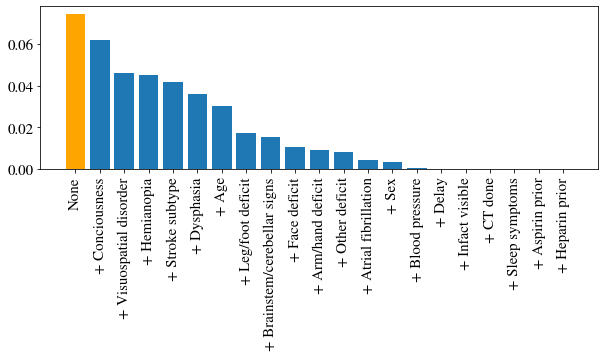

In [80]:
plt.figure(figsize = (10, 3))
xlabels = list(regrets_cumulative.keys())
for i in range(1,len(xlabels)):
    xlabels[i] = '+ ' + xlabels[i]
plt.bar(xlabels, regrets_cumulative.values())
plt.bar('None', regrets_cumulative['None'], color='orange')
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/ist_regrets_cumul.pdf', format='pdf', bbox_inches = "tight")
plt.show()